### Data Exploration and Preprocessing and Clean up

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

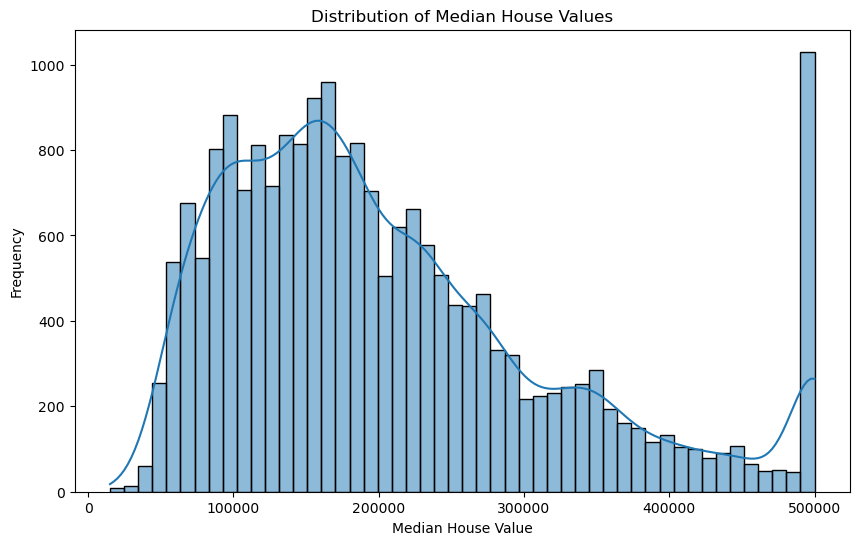

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Setting display options to enhance the readability of DataFrame outputs
# No limit on the number of columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Loading the dataset from a CSV file
# Source: https://www.kaggle.com/datasets/camnugent/california-housing-prices/data
data = pd.read_csv('housing.csv')

# Initial data exploration and understanding
print(data.head())
print(data.describe())
print(data.info())

# Handling missing values
# Using the data.isnull().sum(), shows total_bedrooms is missing 207 data
print(data.isnull().sum())

# Cleaning up the data and filling the missing values by filling with the median
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace=True)

# Visualizations for Initial Data Understanding
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['median_house_value'], bins=50, kde=True)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

# Removing outliers, Removing outliers in 'median_house_value' using IQR
q1 = data['median_house_value'].quantile(0.25)
q3 = data['median_house_value'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data = data[(data['median_house_value'] >= lower_bound) & (data['median_house_value'] <= upper_bound)]

### Feature Engineering

In [2]:
# Adding feature engineering
# Creating new features that might help improve the model's predictions
data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']

### Model Implementation and Baseline Comparison

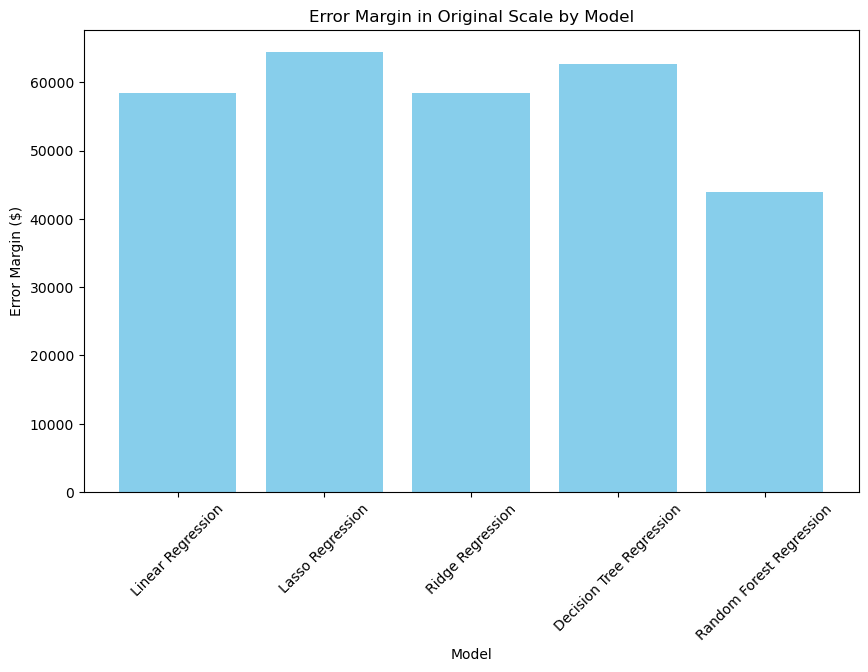

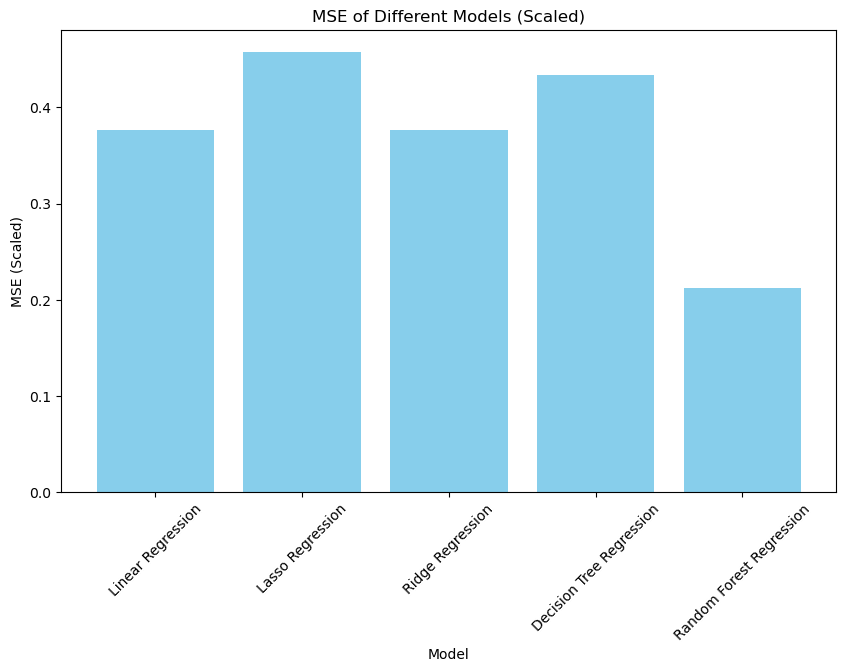

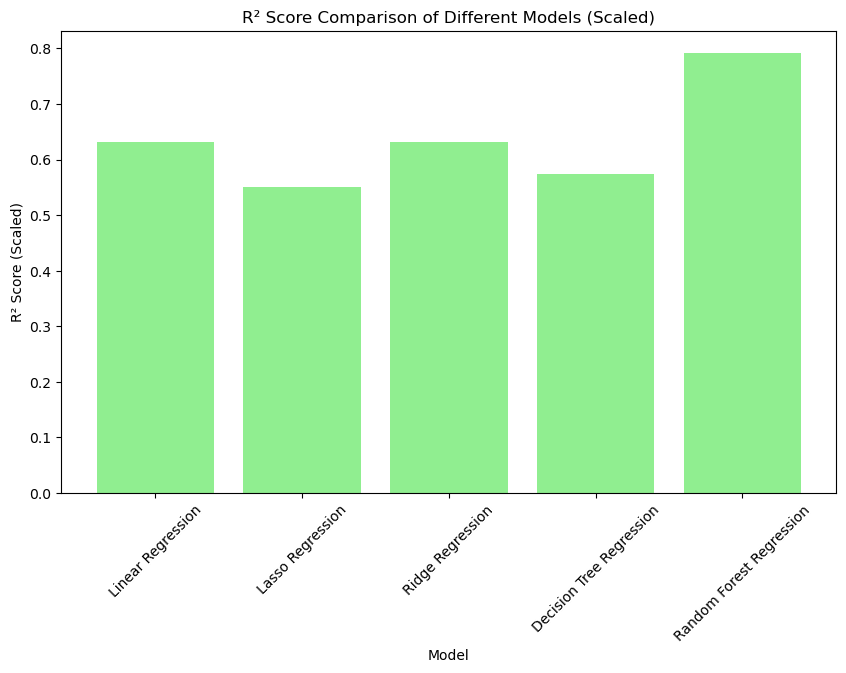

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Encoding categorical variables using one-hot encoding to make the dataset suitable for regression models
# This converts categorical columns into numerical format, where each category is represented by a new binary column
data_encoded = pd.get_dummies(data, columns=['ocean_proximity'])

# Preparing the dataset for training and testing
# The target variable ('median_house_value') is separated from the features
X = data_encoded.drop('median_house_value', axis=1)
y = data_encoded['median_house_value']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features to standardize the data
# StandardScaler removes the mean and scales features to unit variance
# This is important for models like Linear Regression
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable for regression models to improve performance
scaler_Y = StandardScaler()
y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1)).flatten()

# Defining a dictionary of regression models to evaluate 
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),  # Lasso with regularization to prevent overfitting
    'Ridge Regression': Ridge(alpha=1.0),  # Ridge with regularization to prevent overfitting
    'Decision Tree Regression': DecisionTreeRegressor(),  # Non-linear model for capturing complex patterns
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42)  # Ensemble of decision trees for improved accuracy
}

# Initializing dictionaries to store predictions and metrics
predictions_dict = {}
model_metrics = {}
model_mse = {}
model_r2 = {}

# Training each model, making predictions, and evaluating performance
for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)  # Training the model
    predictions_scaled = model.predict(X_test_scaled)  # Making predictions on the scaled test set
    
    # Inversely transform predictions to the original scale for interpretability
    predictions = scaler_Y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    predictions_dict[name] = predictions
    
    # Calculating Mean Squared Error (MSE) and R² score on the scaled test set
    mse_scaled = mean_squared_error(y_test_scaled, predictions_scaled)
    r2_scaled = r2_score(y_test_scaled, predictions_scaled)
    
    model_mse[name] = mse_scaled
    model_r2[name] = r2_scaled
    
    # Calculating MSE on the original scale and deriving the error margin for practical evaluation
    mse_original = mean_squared_error(y_test, predictions)
    error_margin = math.sqrt(mse_original)
    
    # Storing metrics for each model in a dictionary for easy comparison
    model_metrics[name] = {'MSE_Scaled': mse_scaled, 'R²_Scaled': r2_scaled, 'Error Margin ($)': error_margin}


# Visualizing the Error Margin in Original Scale for each model
names = list(model_metrics.keys())
error_margins = [model_metrics[name]['Error Margin ($)'] for name in names]
plt.figure(figsize=(10, 6))
plt.bar(names, error_margins, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Error Margin ($)')
plt.title('Error Margin in Original Scale by Model')
plt.xticks(rotation=45)
plt.show()

models = list(model_mse.keys())
mse_values = list(model_mse.values())
r2_values = list(model_r2.values())

# MSE Visualization
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MSE (Scaled)')
plt.title('MSE of Different Models (Scaled)')
plt.xticks(rotation=45)
plt.show()

# R² Score Visualization
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('R² Score (Scaled)')
plt.title('R² Score Comparison of Different Models (Scaled)')
plt.xticks(rotation=45)
plt.show()

### Visualizations for Data Exploration

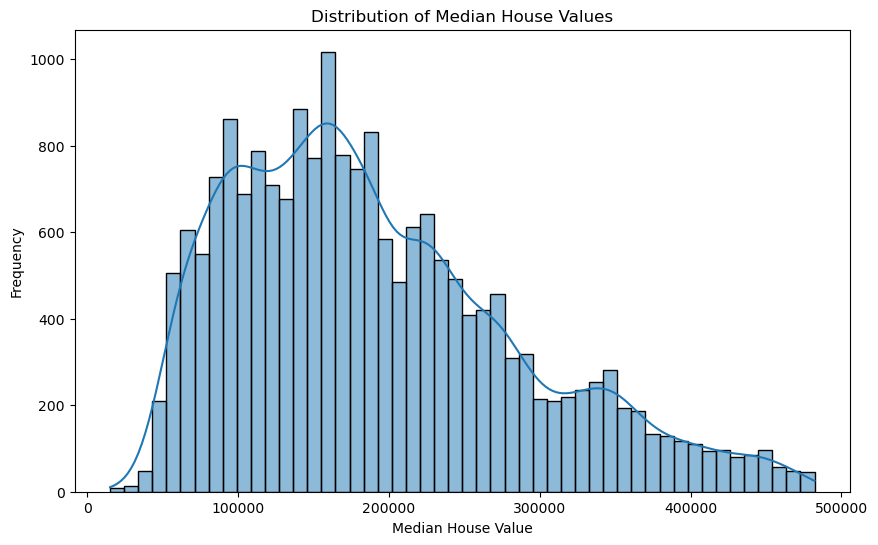

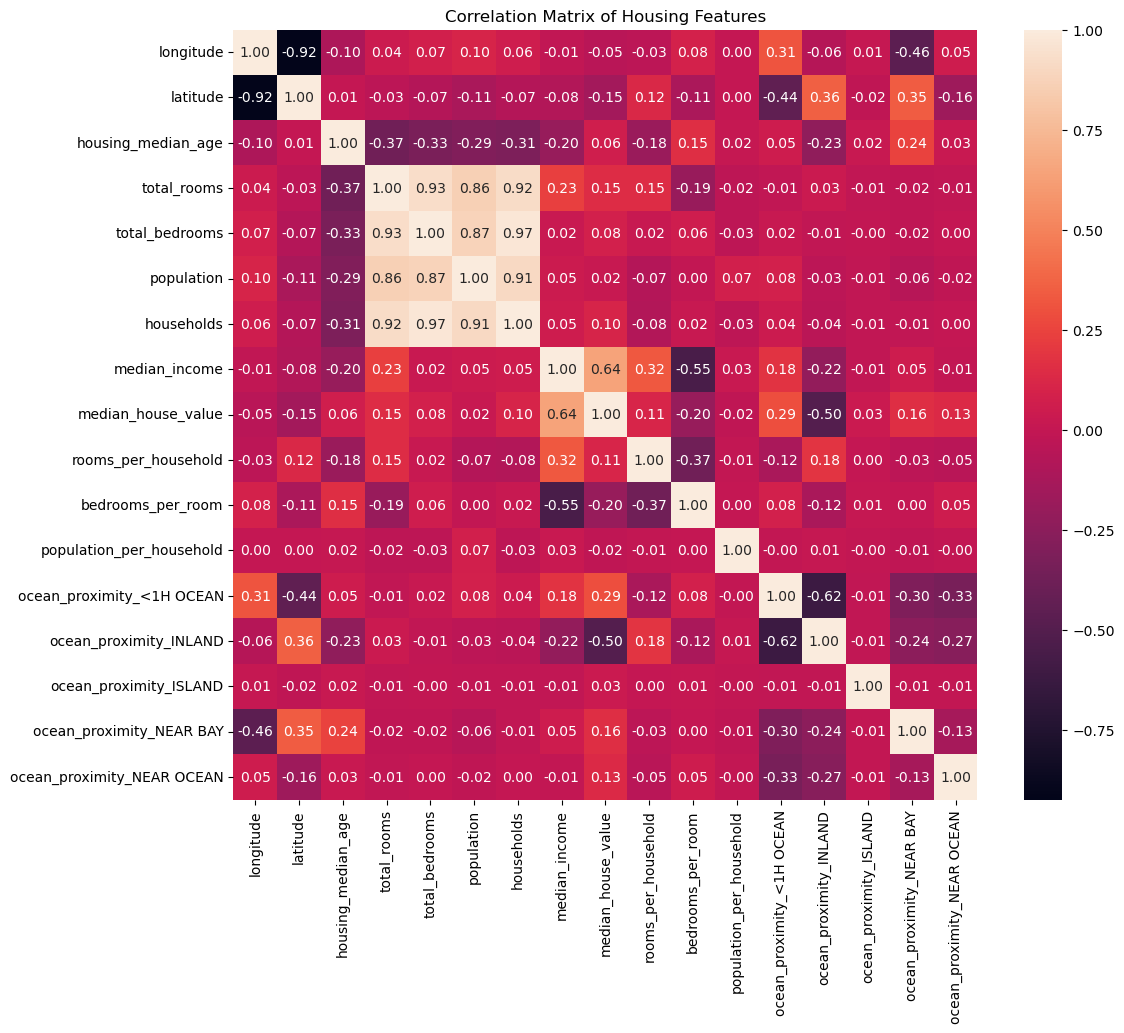

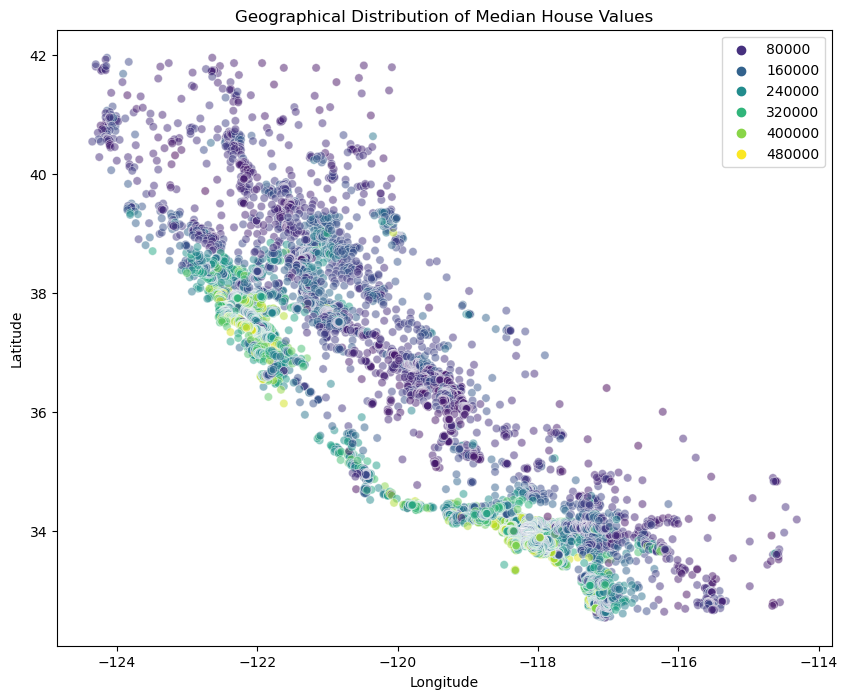

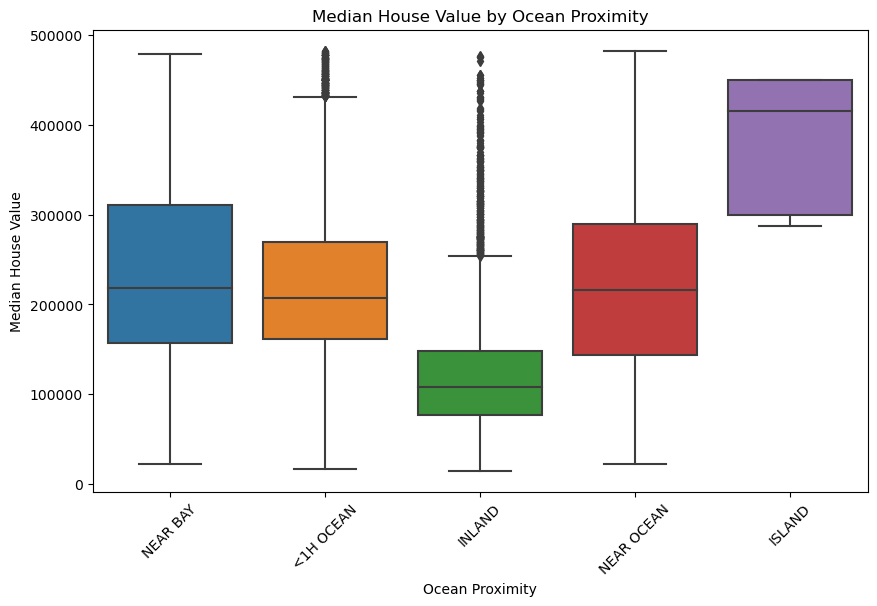

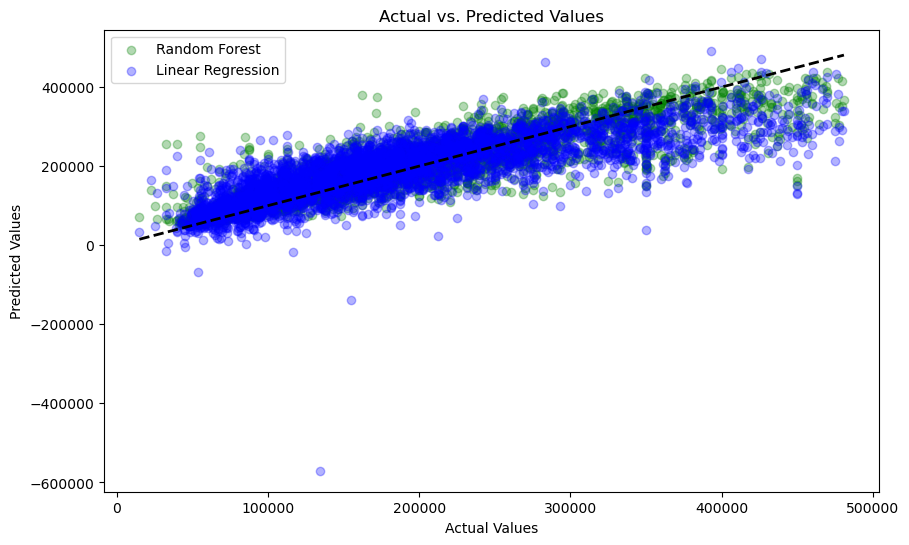

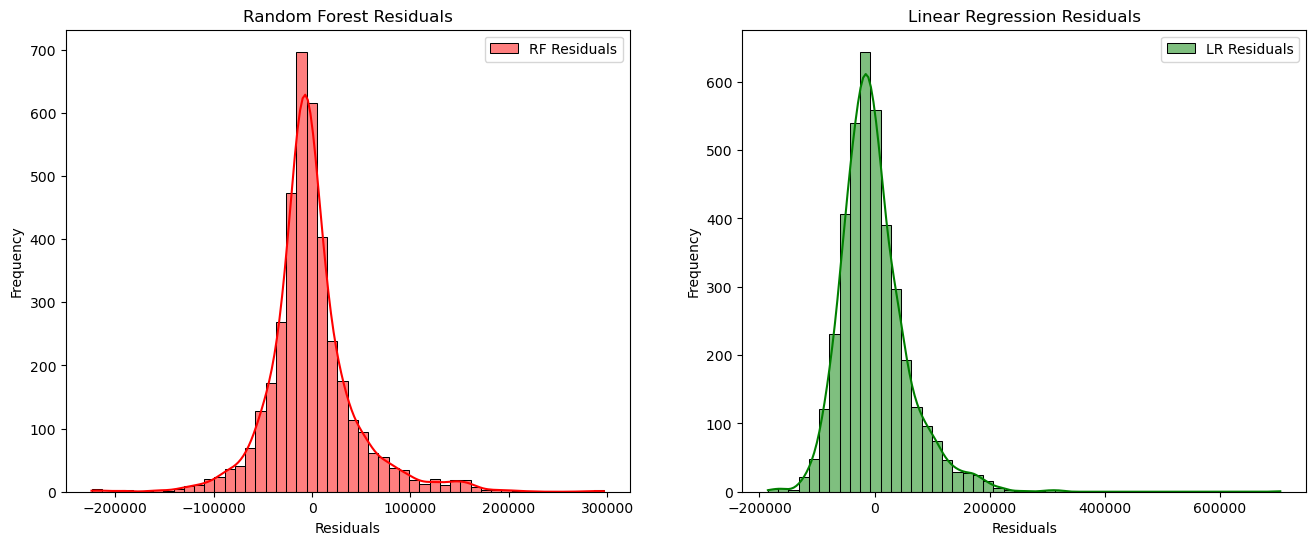

In [4]:
# Visualization for Distribution
def plot_target_distribution():
    plt.figure(figsize=(10, 6))
    sns.histplot(data['median_house_value'], bins=50, kde=True)
    plt.title('Distribution of Median House Values')
    plt.xlabel('Median House Value')
    plt.ylabel('Frequency')
    plt.show()

plot_target_distribution()

# Visualization for correlation matrix heatmap
def plot_correlation_matrix():
    plt.figure(figsize=(12, 10))
    sns.heatmap(data_encoded.corr(), annot=True, fmt=".2f", annot_kws={"size": 10})
    plt.title('Correlation Matrix of Housing Features')
    plt.show()

plot_correlation_matrix()

# Visualization for geographical distribution plot
def plot_geographical_distribution():
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='longitude', y='latitude', data=data, hue='median_house_value', palette='viridis', alpha=0.5)
    plt.title('Geographical Distribution of Median House Values')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

plot_geographical_distribution()

# Visualization for box plot for median house value by ocean proximity
def plot_ocean_proximity_boxplot():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ocean_proximity', y='median_house_value', data=data)
    plt.title('Median House Value by Ocean Proximity')
    plt.xlabel('Ocean Proximity')
    plt.ylabel('Median House Value')
    plt.xticks(rotation=45)
    plt.show()

plot_ocean_proximity_boxplot()

# Visualization for actual vs. predicted values plot
def plot_actual_vs_predicted():
    # Assuming 'lr_predictions' and 'rf_predictions' are generated from Linear Regression and Random Forest models respectively
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions_dict['Random Forest Regression'], alpha=0.3, label='Random Forest', color='green')
    plt.scatter(y_test, predictions_dict['Linear Regression'], alpha=0.3, label='Linear Regression', color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

plot_actual_vs_predicted()

# Visualization for histogram of residuals
def plot_residuals_histogram():
    fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
    sns.histplot(y_test - predictions_dict['Random Forest Regression'], bins=50, kde=True, color='red', ax=axs[0], label='RF Residuals')
    axs[0].set_title('Random Forest Residuals')
    
    sns.histplot(y_test - predictions_dict['Linear Regression'], bins=50, kde=True, color='green', ax=axs[1], label='LR Residuals')
    axs[1].set_title('Linear Regression Residuals')
    
    for ax in axs:
        ax.set_xlabel('Residuals')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.show()

plot_residuals_histogram()

### Feature Importance Visualization

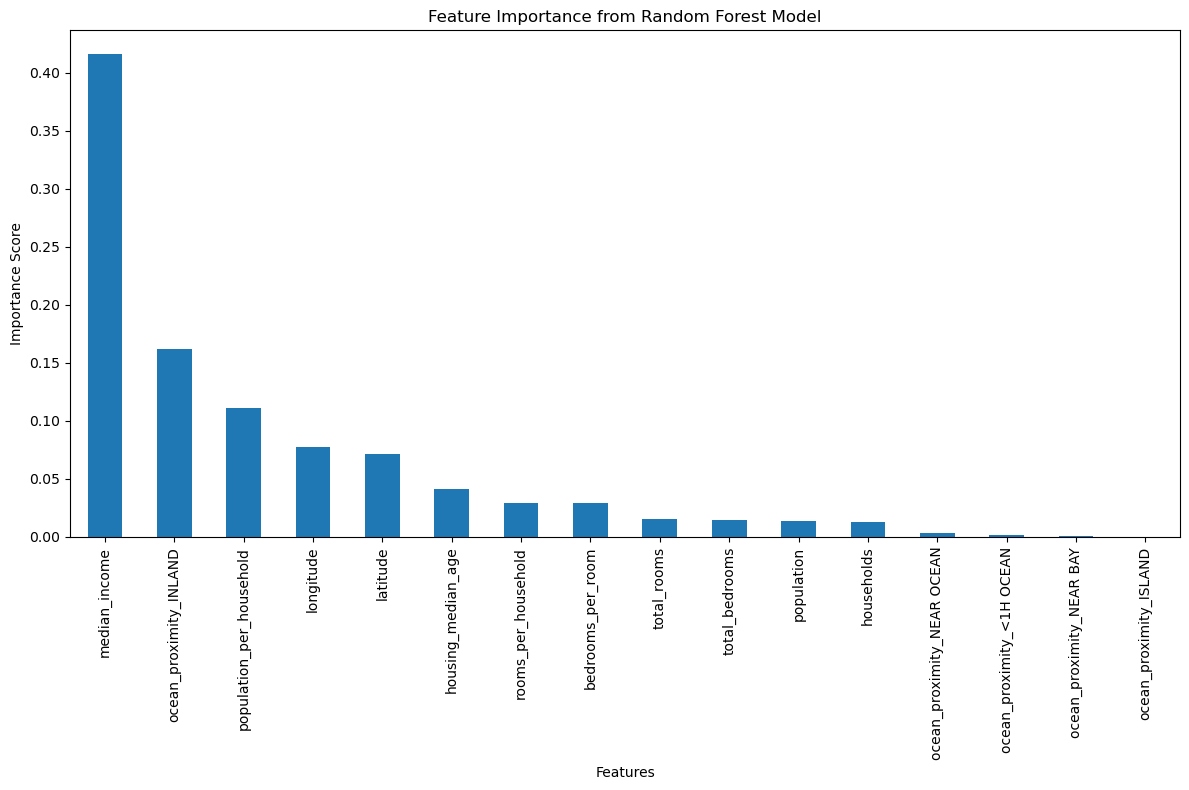

/Users/kenny/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3x/wzjs29n92fx09kv4cylpczg40000gn/T/ipykernel_50189/3372215494.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


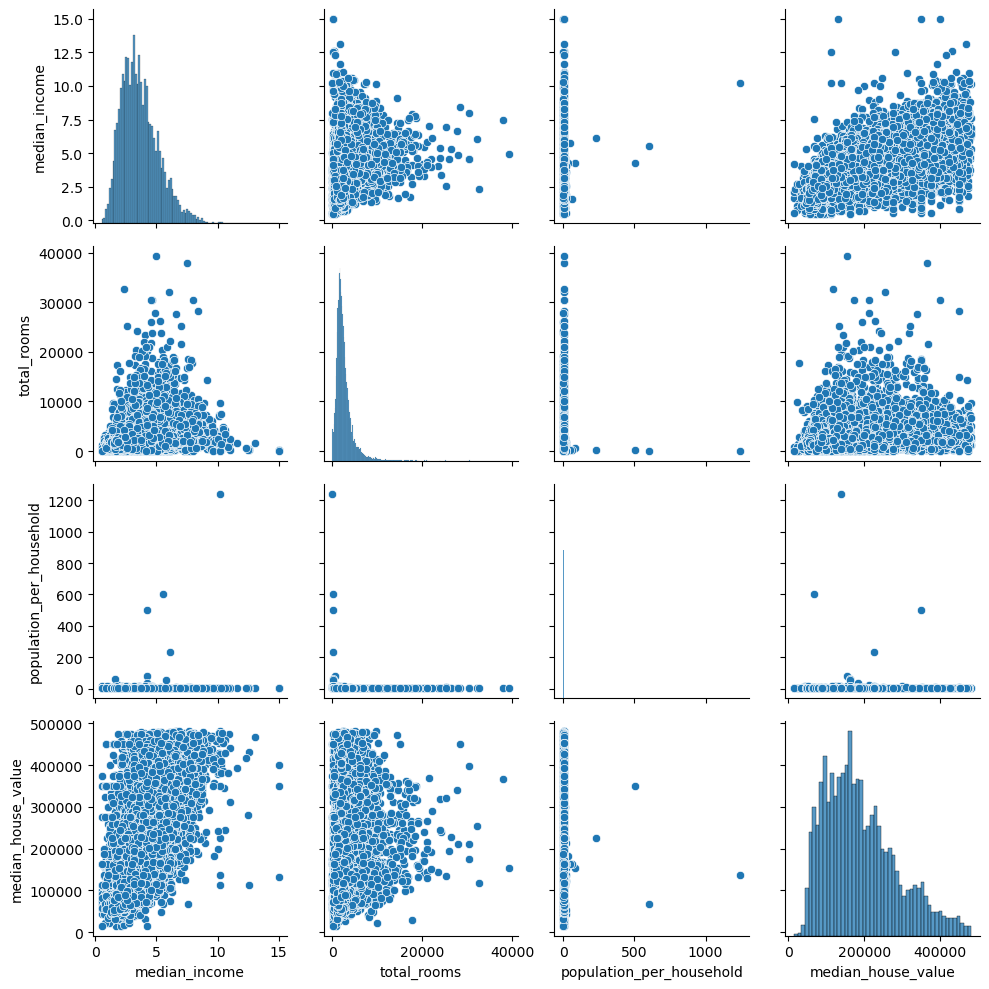

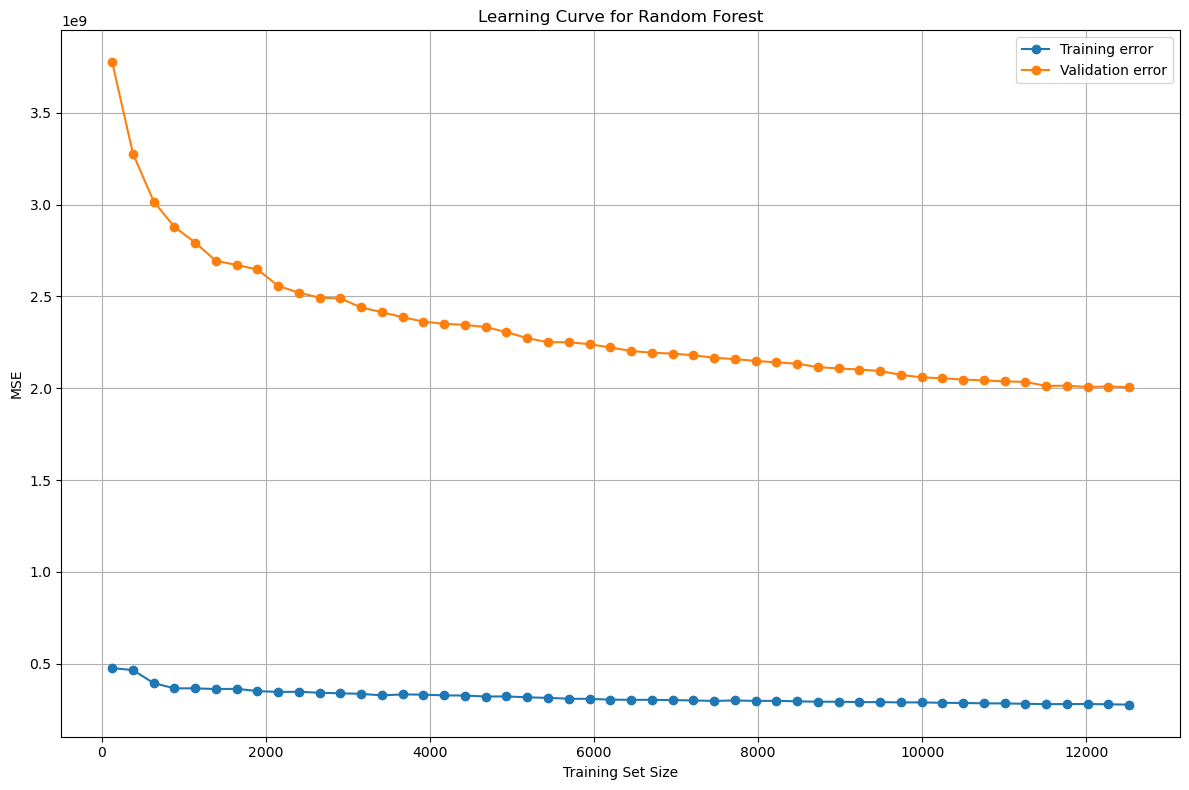

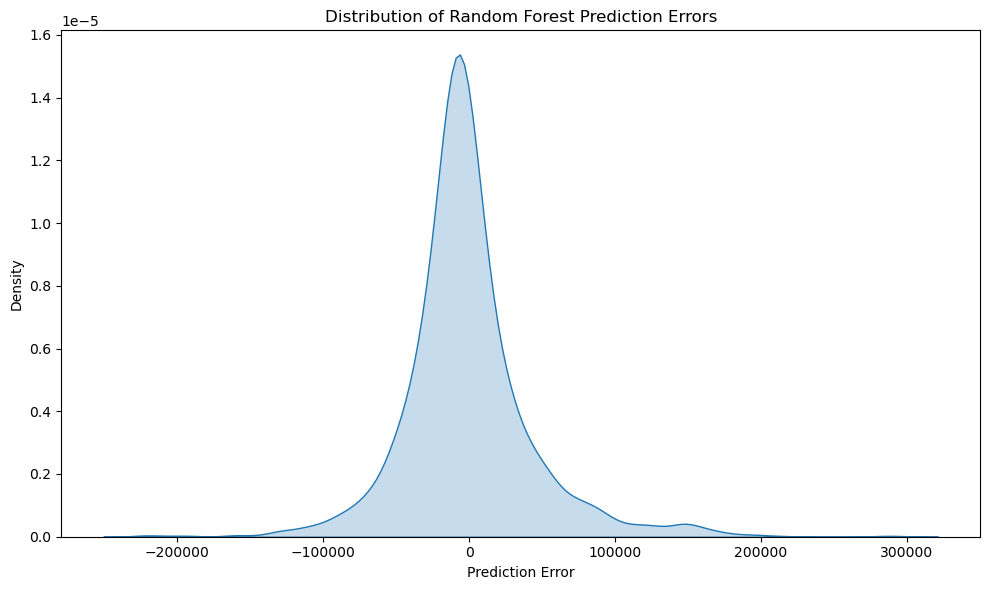

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Visualizing pairwise relationships with a pair plot
features = ['median_income', 'total_rooms', 'population_per_household', 'median_house_value']
subset_data = data[features].dropna()  # Ensure no NaN values for plotting

sns.pairplot(subset_data)
plt.tight_layout()
plt.show()

# Plotting the learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.01, 1.0, 50),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training error')
plt.plot(train_sizes, validation_scores_mean, 'o-', label='Validation error')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Error Distribution Plot for Random Forest model
rf_residuals = y_test - rf_predictions

plt.figure(figsize=(10, 6))
sns.kdeplot(rf_residuals, fill=True)
plt.title('Distribution of Random Forest Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Actual vs. Predicted Values with Confidence Interval

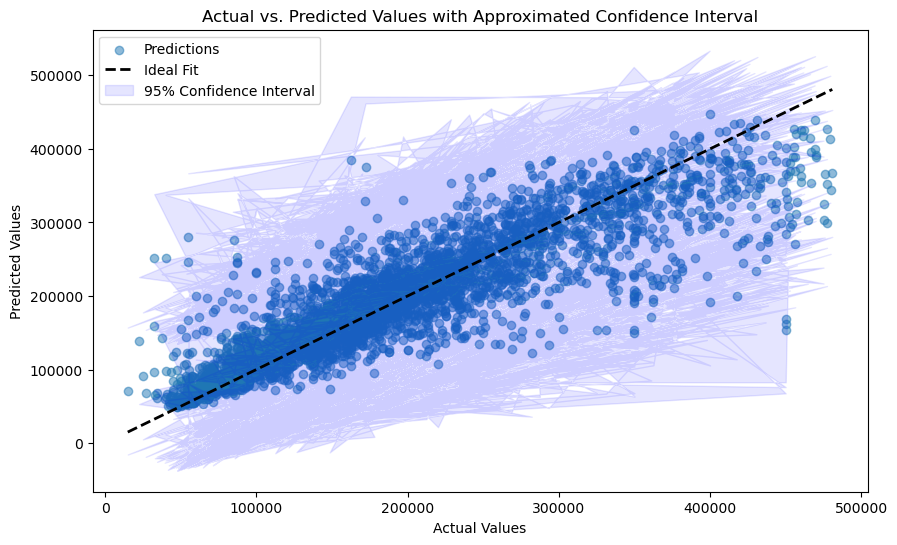

In [6]:
import numpy as np
# Calculate residuals
residuals = y_test - rf_predictions

# Calculate the standard deviation of the residuals
residual_std = np.std(residuals)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')

# Overlaying the approximation of the confidence interval
# Use 1.96 * std for the 95% confidence interval
lower_bound = rf_predictions - 1.96 * residual_std
upper_bound = rf_predictions + 1.96 * residual_std

# Plotting the confidence interval
plt.fill_between(y_test, lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Approximated Confidence Interval')
plt.legend()
plt.show()